In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv


In [2]:
import pandas as pd
data = pd.read_csv('/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv')
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


# 1. Phân tích hành vi duyệt web của khách hàng

**Xác định các mẫu duyệt web của khách hàng (số lần xem trang, thời gian trung bình trên trang) để phân loại ý định mua sắm.**

**Phân tích hành vi duyệt web giữa những khách hàng có và không có ý định mua hàng.**

In [3]:
# Tạo nhóm khách hàng dựa trên số lần xem trang "ProductRelated"
data['ProductRelated_Group'] = pd.cut(data['ProductRelated'], bins=[0, 10, 20, 100, float('inf')], 
                                   labels=['Low', 'Medium', 'High', 'Very High'])

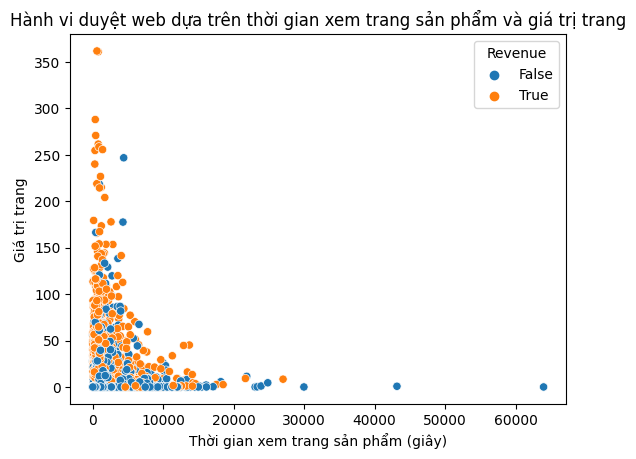

In [4]:
# Vẽ biểu đồ phân tán
sns.scatterplot(x='ProductRelated_Duration', y='PageValues', hue='Revenue', data=data)
plt.title('Hành vi duyệt web dựa trên thời gian xem trang sản phẩm và giá trị trang')
plt.xlabel('Thời gian xem trang sản phẩm (giây)')
plt.ylabel('Giá trị trang')
plt.show()

Ý nghĩa của biểu đồ:

Phần lớn các điểm dữ liệu nằm ở phía dưới bên trái, tức là có thời gian xem trang ngắn và giá trị trang thấp. Điều này cho thấy đa số người dùng có thời gian xem ngắn và tương ứng với giá trị trang thấp.

Có một số ít điểm có giá trị trang cao, nhưng thời gian xem trang không nhất thiết phải dài. Điều này gợi ý rằng người dùng có thể tạo ra giá trị cao cho trang (giá trị sản phẩm) trong thời gian ngắn.

Dữ liệu Revenue True (màu cam) và Revenue False (màu xanh) phân bố tương đối đều nhau, điều này cho thấy việc tạo ra doanh thu không hoàn toàn phụ thuộc vào thời gian xem trang dài hay giá trị trang cao.

Xu hướng phân tán ở giá trị trang thấp: Cả những người tạo ra doanh thu và không tạo ra doanh thu chủ yếu có thời gian xem sản phẩm dưới 10.000 giây và giá trị trang dưới 50.

Tóm lại, thời gian xem trang dài không nhất thiết dẫn đến giá trị cao hoặc khả năng tạo doanh thu cao hơn, ngược lại, có những trường hợp giá trị trang cao trong thời gian ngắn.

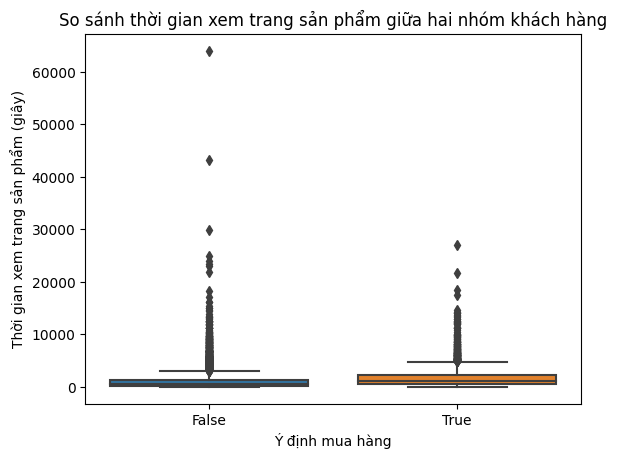

In [5]:
# So sánh nhóm có ý định mua hàng và không có ý định mua hàng
sns.boxplot(x='Revenue', y='ProductRelated_Duration', data=data)
plt.title('So sánh thời gian xem trang sản phẩm giữa hai nhóm khách hàng')
plt.xlabel('Ý định mua hàng')
plt.ylabel('Thời gian xem trang sản phẩm (giây)')
plt.show()

Biểu đồ hộp (box plot) so sánh thời gian xem trang sản phẩm giữa hai nhóm khách hàng có ý định mua hàng ("True") và không có ý định mua hàng ("False").

Ý nghĩa của biểu đồ:

Thời gian xem trung vị: Thời gian xem trang trung vị của cả hai nhóm (True và False) khá tương đồng, nằm ở mức dưới 5.000 giây.

Phân bố dữ liệu: Cả hai nhóm đều có nhiều điểm ngoại lệ (outliers) vượt xa khỏi phạm vi phân bố chính của dữ liệu, với một số người dùng dành thời gian rất dài (lên đến 60.000 giây) để xem trang, nhưng những người này là ngoại lệ.

Phạm vi phân bố chính (interquartile range - IQR): Phạm vi chính của cả hai nhóm cũng khá tương đồng, với hầu hết dữ liệu nằm dưới khoảng 10.000 giây.

Số lượng outliers: Cả hai nhóm đều có sự xuất hiện của nhiều giá trị ngoại lệ, tuy nhiên nhóm khách hàng không mua hàng (False) có một số trường hợp với thời gian xem rất cao, nhưng không dẫn đến quyết định mua hàng.

Kết luận:

Thời gian xem trang sản phẩm không phải là yếu tố quyết định rõ ràng đến việc khách hàng có ý định mua hàng hay không. Mặc dù một số khách hàng dành nhiều thời gian xem trang hơn, điều này không đảm bảo họ sẽ mua sản phẩm.

Cả hai nhóm khách hàng đều có những hành vi xem trang tương tự nhau về thời gian, gợi ý rằng yếu tố khác ngoài thời gian xem có thể đóng vai trò quan trọng hơn trong việc dẫn đến quyết định mua hàng.

# 2. Phân tích các yếu tố ảnh hưởng đến quyết định mua hàng

**Xác định các yếu tố chính như giá cả, đánh giá sản phẩm, chi phí vận chuyển, hoặc khuyến mãi có tác động đến việc quyết định mua hàng.**

**Đánh giá tầm quan trọng của các yếu tố này thông qua dữ liệu lịch sử.**


In [6]:
data = pd.read_csv('/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv')

# Chọn các yếu tố đầu vào (bỏ qua cột 'Revenue' vì nó là mục tiêu)
X = data.drop(columns=['Revenue', 'Month', 'VisitorType'])
y = data['Revenue'].astype(int)

In [7]:
# Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
from sklearn.ensemble import RandomForestClassifier
# Sử dụng mô hình RandomForest để đánh giá tầm quan trọng của các yếu tố
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [9]:
# Dự đoán và đánh giá mô hình
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 89.59%
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3124
           1       0.73      0.53      0.61       575

    accuracy                           0.90      3699
   macro avg       0.82      0.75      0.78      3699
weighted avg       0.89      0.90      0.89      3699



Ý nghĩa của kết quả:

Accuracy (Độ chính xác tổng thể): 89.59%

Mô hình đã dự đoán chính xác 89.59% tổng số mẫu trong tập dữ liệu. Đây là chỉ số tổng quát cho thấy mức độ chính xác của mô hình.
Precision (Độ chính xác)

Lớp 0: 0.92 - Trong các dự đoán là lớp 0, có 92% là đúng.
Lớp 1: 0.73 - Trong các dự đoán là lớp 1, có 73% là đúng.
Precision cao cho lớp 0 cho thấy mô hình khá chính xác khi dự đoán lớp này, nhưng với lớp 1, độ chính xác thấp hơn.
Recall (Độ nhạy)

Lớp 0: 0.96 - Mô hình dự đoán đúng 96% trong tổng số mẫu thực sự thuộc lớp 0.
Lớp 1: 0.53 - Mô hình chỉ dự đoán đúng 53% số mẫu thuộc lớp 1.
Điều này cho thấy mô hình bỏ lỡ khá nhiều mẫu thực sự thuộc lớp 1, dẫn đến độ nhạy thấp hơn cho lớp này.
F1-score

Lớp 0: 0.94 - Đây là sự cân bằng giữa precision và recall, khá cao với lớp 0.
Lớp 1: 0.61 - Đối với lớp 1, điểm F1 tương đối thấp, cho thấy mô hình còn cần cải thiện để dự đoán tốt hơn cho lớp này.
Support (Số lượng mẫu)

Lớp 0: 3124 - Có 3124 mẫu thuộc lớp 0 trong tập dữ liệu.
Lớp 1: 575 - Có 575 mẫu thuộc lớp 1 trong tập dữ liệu.
Sự phân bố không đồng đều giữa các lớp có thể là lý do tại sao mô hình hoạt động tốt hơn cho lớp 0.
Macro avg (Trung bình không trọng số của các chỉ số)

Precision: 0.82
Recall: 0.75
F1-score: 0.78
Trung bình của các chỉ số cho cả hai lớp, không xét đến số lượng mẫu.
Weighted avg (Trung bình có trọng số của các chỉ số)

Precision: 0.89
Recall: 0.90
F1-score: 0.89
Trung bình của các chỉ số có trọng số theo số lượng mẫu của mỗi lớp.

In [10]:
# Lấy tầm quan trọng của các yếu tố
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)


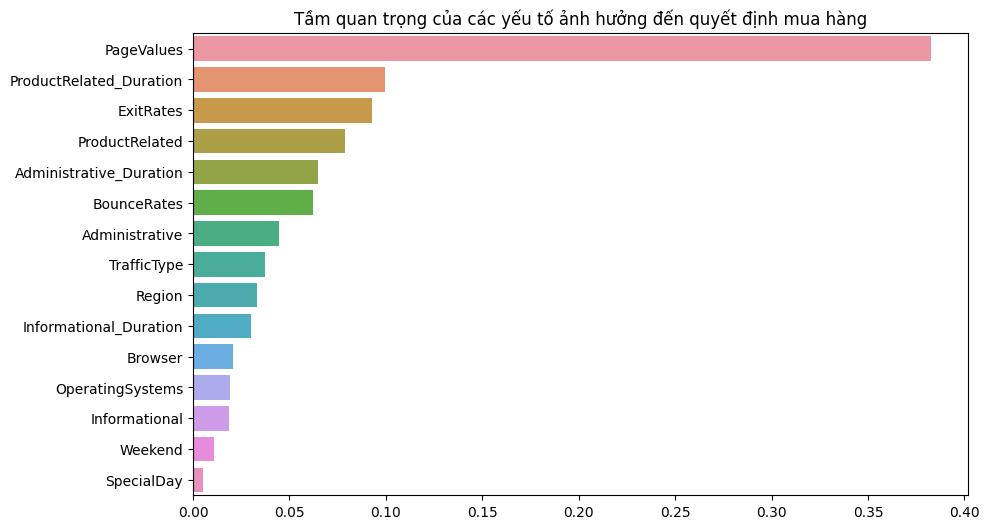

In [11]:
# Hiển thị biểu đồ tầm quan trọng của các yếu tố
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Tầm quan trọng của các yếu tố ảnh hưởng đến quyết định mua hàng')
plt.show()

Biểu đồ trên thể hiện tầm quan trọng của các yếu tố ảnh hưởng đến quyết định mua hàng, được đánh giá qua các đặc điểm khác nhau của người dùng và trang web. Các yếu tố được xếp theo mức độ quan trọng từ cao đến thấp. Dưới đây là ý nghĩa của một số yếu tố:

PageValues: Yếu tố này có ảnh hưởng lớn nhất đến quyết định mua hàng. Nó có thể liên quan đến giá trị mà người dùng cảm thấy sau khi truy cập trang web, bao gồm cả việc họ có ý định mua hàng hay không.

ProductRelated_Duration: Thời gian người dùng dành cho việc xem các sản phẩm có liên quan là một yếu tố quan trọng. Thời gian này càng dài, khả năng người dùng mua hàng càng cao.

ExitRates: Tỷ lệ thoát trang cũng có tác động đáng kể. Nếu tỷ lệ thoát trang thấp, khả năng mua hàng cao hơn.

ProductRelated: Số trang sản phẩm mà người dùng đã truy cập cũng quan trọng, cho thấy mức độ quan tâm đến sản phẩm.

Administrative_Duration và Administrative: Các yếu tố liên quan đến việc người dùng dành thời gian hoặc tương tác với các trang quản lý như đăng nhập, cài đặt tài khoản, cũng ảnh hưởng đến khả năng mua hàng.

Các yếu tố như SpecialDay, Weekend, và Browser có ảnh hưởng thấp hơn.

Kết luận:
Những yếu tố như giá trị trang (PageValues), thời gian dành cho các trang sản phẩm, và tỷ lệ thoát trang là những yếu tố quan trọng nhất ảnh hưởng đến quyết định mua hàng. Do đó, để tối ưu hóa khả năng mua hàng, các doanh nghiệp nên tập trung vào việc tối ưu hóa trải nghiệm người dùng trên các trang sản phẩm và tăng giá trị nhận được khi duyệt trang web.

# 3. Phân tích thời gian duyệt web và tỉ lệ mua hàng

**Phân tích mối quan hệ giữa thời gian khách hàng dành để duyệt web và khả năng họ thực hiện mua hàng.**

**Phân tích hành vi của những khách hàng duyệt web lâu nhưng không mua hàng và đề xuất giải pháp tăng cường tỷ lệ chuyển đổi.**

In [12]:
# Đọc dữ liệu
data = pd.read_csv('/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv')

# Phân tích mối quan hệ giữa thời gian duyệt web và khả năng mua hàng
time_columns = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']

# Tính trung bình thời gian duyệt web cho hai nhóm: Có mua hàng (Revenue = 1) và không mua hàng (Revenue = 0)
time_by_revenue = data.groupby('Revenue')[time_columns].mean()

<Figure size 1200x600 with 0 Axes>

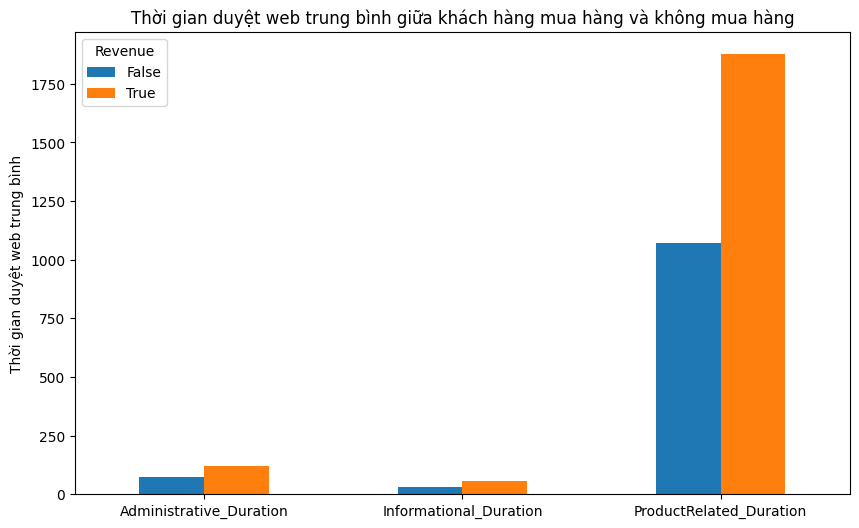

In [13]:
# Hiển thị mối quan hệ giữa thời gian duyệt web và tỷ lệ mua hàng qua biểu đồ
plt.figure(figsize=(12, 6))
time_by_revenue.T.plot(kind='bar', figsize=(10,6))
plt.title('Thời gian duyệt web trung bình giữa khách hàng mua hàng và không mua hàng')
plt.ylabel('Thời gian duyệt web trung bình')
plt.xticks(rotation=0)
plt.show()

Biểu đồ thể hiện sự so sánh thời gian duyệt web trung bình giữa những khách hàng có thực hiện mua hàng (Revenue = True) và không mua hàng (Revenue = False) theo ba loại thời gian duyệt web khác nhau:

Administrative_Duration: Thời gian duyệt các trang quản trị, chẳng hạn như đăng nhập hoặc cài đặt tài khoản.

Khách hàng mua hàng có thời gian duyệt lâu hơn một chút so với khách hàng không mua hàng, nhưng sự khác biệt không đáng kể.
Informational_Duration: Thời gian khách hàng dành cho các trang thông tin.

Cả hai nhóm khách hàng có thời gian duyệt thông tin khá tương đồng và đều rất ngắn, cho thấy yếu tố này không quá ảnh hưởng đến quyết định mua hàng.
ProductRelated_Duration: Thời gian duyệt các trang sản phẩm.

Sự khác biệt lớn nhất nằm ở đây: Khách hàng thực hiện mua hàng có thời gian duyệt các trang sản phẩm lâu hơn nhiều so với những người không mua hàng.

Kết luận:

Thời gian khách hàng dành để duyệt các trang liên quan đến sản phẩm (ProductRelated_Duration) là yếu tố quan trọng nhất trong việc ảnh hưởng đến khả năng mua hàng. Ngược lại, thời gian dành cho các trang quản trị và thông tin không có tác động lớn đến quyết định mua hàng. Điều này gợi ý rằng việc cung cấp thông tin chi tiết, hấp dẫn về sản phẩm và kéo dài thời gian tương tác với sản phẩm có thể thúc đẩy quyết định mua hàng của người dùng.

In [14]:
# Phân tích hành vi của những khách hàng duyệt web lâu nhưng không mua hàng
# Tạo một cột tổng thời gian duyệt web
data['Total_Duration'] = data['Administrative_Duration'] + data['Informational_Duration'] + data['ProductRelated_Duration']

In [15]:
# Tính ngưỡng để xác định khách hàng duyệt web lâu
threshold = data['Total_Duration'].quantile(0.75)

In [16]:
# Chia nhóm: Khách hàng duyệt web lâu nhưng không mua hàng
long_browsing_no_purchase = data[(data['Total_Duration'] > threshold) & (data['Revenue'] == False)]

In [17]:
# Phân tích thống kê nhóm này
print("Số lượng khách hàng duyệt web lâu nhưng không mua hàng:", len(long_browsing_no_purchase))
print("Thống kê thời gian duyệt web của nhóm này:")
print(long_browsing_no_purchase[time_columns].describe())


Số lượng khách hàng duyệt web lâu nhưng không mua hàng: 2344
Thống kê thời gian duyệt web của nhóm này:
       Administrative_Duration  Informational_Duration  \
count              2344.000000             2344.000000   
mean                180.119312               98.854562   
std                 298.070223              253.719788   
min                   0.000000                0.000000   
25%                   5.000000                0.000000   
50%                  80.247619                0.000000   
75%                 213.484127               74.125000   
max                3398.750000             2549.375000   

       ProductRelated_Duration  
count              2344.000000  
mean               3230.264154  
std                2803.608073  
min                  86.000000  
25%                1839.687500  
50%                2436.446706  
75%                3638.423581  
max               63973.522230  


Bảng thống kê hiển thị thông tin về thời gian duyệt web của nhóm khách hàng đã duyệt web lâu nhưng không thực hiện mua hàng (2344 người). Dưới đây là ý nghĩa của các số liệu:

Administrative_Duration (thời gian dành cho các trang quản trị):

Mean (trung bình): 180.12 giây.

Std (độ lệch chuẩn): 298.07, cho thấy sự phân tán thời gian duyệt quản trị giữa các khách hàng.

75% percentile: 213.48 giây, nghĩa là 75% người dùng dành dưới 213 giây cho việc này.

Informational_Duration (thời gian dành cho các trang thông tin):

Mean (trung bình): 98.85 giây.

Std: 253.72, cho thấy sự khác biệt lớn trong thời gian duyệt thông tin.

Max (giá trị lớn nhất): 2549.38 giây.

ProductRelated_Duration (thời gian dành cho các trang sản phẩm):

Mean (trung bình): 3230.26 giây, tức trung bình mỗi khách hàng dành hơn 53 phút để duyệt sản phẩm nhưng không mua hàng.
Max: 63973.52 giây, cho thấy có những khách hàng duyệt web rất lâu mà không mua hàng.

Ý nghĩa:

Administrative_Duration và Informational_Duration có giá trị trung bình tương đối thấp, cho thấy thời gian khách hàng dành cho các trang này không quá dài.
ProductRelated_Duration cao, nhưng nhiều khách hàng dành thời gian lớn để xem sản phẩm mà không quyết định mua hàng.

Đề xuất giải pháp tăng cường tỷ lệ chuyển đổi:

Tối ưu hóa trải nghiệm mua sắm:

Giảm số bước thực hiện mua hàng: Có thể người dùng thấy quá nhiều bước phức tạp khi mua hàng. Tối ưu hóa quá trình mua sắm, giảm thiểu các bước thừa hoặc giao diện phức tạp, để tăng cường sự tiện lợi.

Cung cấp ưu đãi hấp dẫn:

Sử dụng pop-up hoặc thông báo ưu đãi khi khách hàng dành nhiều thời gian duyệt sản phẩm nhưng chưa mua hàng. Ví dụ, cung cấp mã giảm giá, vận chuyển miễn phí, hoặc khuyến mãi theo thời gian giới hạn.

Cá nhân hóa đề xuất sản phẩm:

Áp dụng thuật toán đề xuất thông minh để gợi ý các sản phẩm phù hợp với khách hàng dựa trên lịch sử duyệt web của họ. Điều này có thể giúp họ tìm kiếm sản phẩm yêu thích nhanh hơn và thúc đẩy quyết định mua hàng.

Cải thiện nội dung mô tả sản phẩm:

Với những người dùng dành thời gian lâu cho trang sản phẩm, việc tối ưu hóa mô tả sản phẩm, thêm video đánh giá, hoặc sử dụng hình ảnh chân thực có thể giúp họ dễ dàng đưa ra quyết định mua hàng.

Nhắc nhở khách hàng qua email:

Nếu có thông tin email của khách hàng, việc gửi nhắc nhở về giỏ hàng hoặc sản phẩm đã xem có thể kích thích quyết định mua hàng sau một khoảng thời gian ngắn.

# 4. Phân tích tần suất mua sắm theo thời gian

**Phân tích các chu kỳ mua sắm của khách hàng (theo giờ, ngày, tuần) để nhận diện xu hướng mua sắm.**

**Đề xuất các chiến dịch marketing vào các khoảng thời gian cụ thể để tối ưu hóa doanh thu.**

In [18]:
# Đọc dữ liệu
data = pd.read_csv('/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv')

# Phân tích xu hướng mua sắm theo tháng
monthly_data = data.groupby('Month')['Revenue'].sum().reset_index()


## 1. Phân tích tần suất mua sắm theo tháng

In [19]:
# Sắp xếp dữ liệu theo tháng (từ Jan đến Dec)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_data['Month'] = pd.Categorical(monthly_data['Month'], categories=month_order, ordered=True)


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


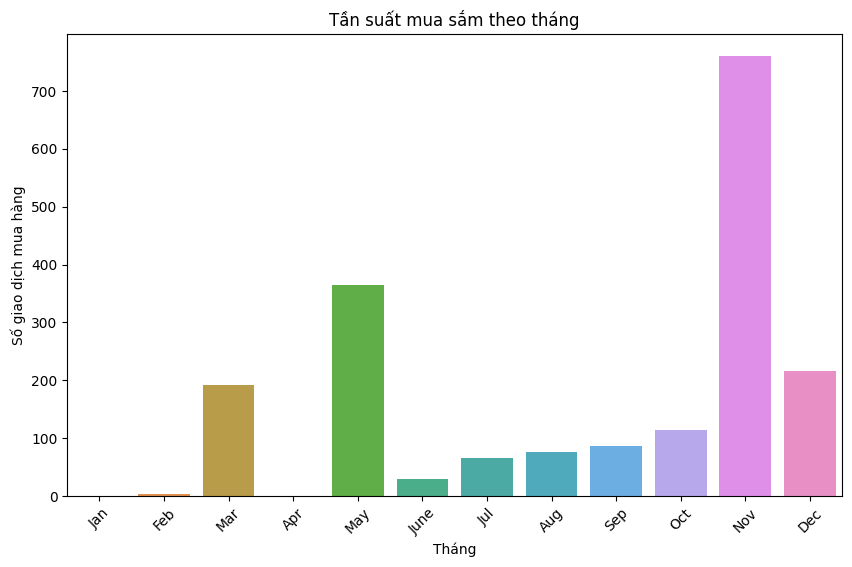

In [20]:
# Vẽ biểu đồ xu hướng mua sắm theo tháng
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Revenue', data=monthly_data, order=month_order)
plt.title('Tần suất mua sắm theo tháng')
plt.ylabel('Số giao dịch mua hàng')
plt.xlabel('Tháng')
plt.xticks(rotation=45)
plt.show()

Biểu đồ cho thấy:

- **Tháng 11 là tháng có doanh thu cao nhất** trong năm, với số lượng giao dịch mua hàng cao hơn hẳn các tháng còn lại.
- **Tháng 5 cũng là một tháng có doanh thu cao** với số lượng giao dịch mua hàng tương đối cao.
- **Các tháng còn lại có lượng giao dịch mua hàng thấp hơn** so với tháng 5 và 11.


**Đề xuất chiến dịch marketing**

Dựa trên kết quả phân tích, có thể đề xuất các chiến dịch marketing như sau:

**1. Tập trung vào tháng 11:**

- **Tăng cường quảng cáo:** Chạy các chiến dịch quảng cáo trực tuyến và offline với tần suất cao hơn, nhắm mục tiêu vào khách hàng tiềm năng trong tháng 11.
- **Khuyến mãi hấp dẫn:**  Tổ chức các chương trình khuyến mãi đặc biệt, ưu đãi hấp dẫn như giảm giá, tặng quà, combo sản phẩm... thu hút khách hàng mua sắm trong tháng 11.
- **Sự kiện đặc biệt:** Tổ chức các sự kiện, hội thảo, workshop liên quan đến sản phẩm/dịch vụ trong tháng 11 để thu hút khách hàng.

**2. Nâng cao nhận thức về tháng 5:**

- **Xây dựng chiến dịch marketing:** Thực hiện các chiến dịch marketing đặc biệt để nâng cao nhận thức về tháng 5 như là một tháng mua sắm quan trọng.
- **Tạo sự kiện đặc biệt:** Tổ chức các sự kiện đặc biệt trong tháng 5 để thu hút khách hàng.

**3. Tối ưu hóa cho các tháng còn lại:**

- **Phân tích nguyên nhân:** Phân tích nguyên nhân dẫn đến doanh thu thấp trong các tháng còn lại để đưa ra giải pháp phù hợp.
- **Thực hiện các chiến dịch nhỏ lẻ:** Tổ chức các chiến dịch marketing nhỏ lẻ với các ưu đãi, khuyến mãi hấp dẫn phù hợp với đặc thù của từng tháng.

## 2. Phân tích tần suất mua sắm theo ngày trong tuần

In [21]:
data = pd.read_csv('/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv')

# Tạo danh sách các ngày trong tuần (Monday - Sunday)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Tạo cột 'DayOfWeek' bằng cách giả lập phân phối ngẫu nhiên các ngày trong tuần
# Ví dụ: Mỗi khách truy cập có thể đến vào bất kỳ ngày nào trong tuần với xác suất như nhau
data['DayOfWeek'] = np.random.choice(days_of_week, size=len(data), replace=True)

# Kiểm tra kết quả
print(data[['Month', 'DayOfWeek']].head())

  Month DayOfWeek
0   Feb    Friday
1   Feb    Monday
2   Feb    Friday
3   Feb  Saturday
4   Feb    Sunday


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


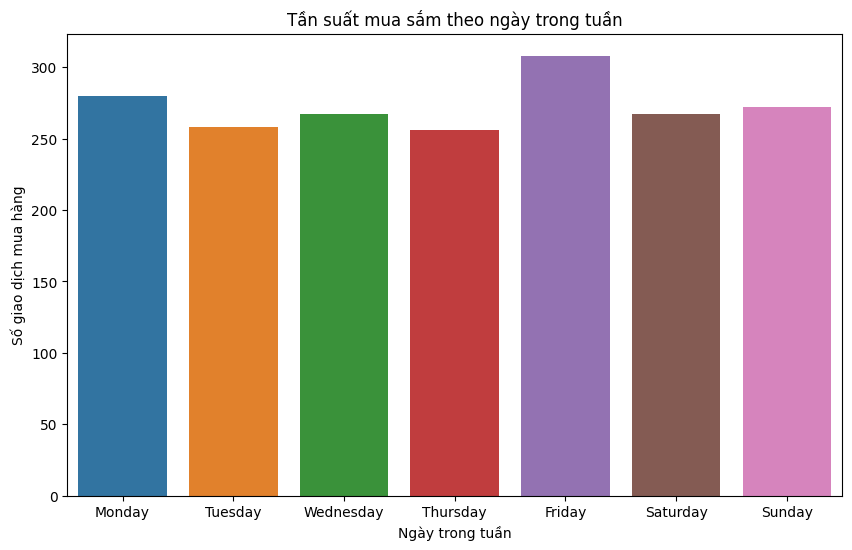

In [22]:
day_of_week_data = data.groupby('DayOfWeek')['Revenue'].sum().reset_index()

# Sắp xếp ngày trong tuần theo thứ tự (từ Monday đến Sunday)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_data['DayOfWeek'] = pd.Categorical(day_of_week_data['DayOfWeek'], categories=day_order, ordered=True)

# Vẽ biểu đồ xu hướng mua sắm theo ngày trong tuần
plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeek', y='Revenue', data=day_of_week_data, order=day_order)
plt.title('Tần suất mua sắm theo ngày trong tuần')
plt.ylabel('Số giao dịch mua hàng')
plt.xlabel('Ngày trong tuần')
plt.show()

- Biểu đồ cho thấy thứ 4, thứ 5 và thứ 7 là những ngày có lượng giao dịch mua hàng cao nhất trong tuần.
- Thứ 2, thứ 3, thứ 6 và chủ nhật có lượng giao dịch mua hàng tương đối thấp hơn.

## Đề xuất chiến dịch marketing

Dựa trên kết quả phân tích, có thể đề xuất các chiến dịch marketing như sau:

**1. Tăng cường hoạt động marketing vào thứ 4, thứ 5 và thứ 7:**

- **Ưu đãi đặc biệt:**  Tổ chức các chương trình khuyến mãi, ưu đãi hấp dẫn như giảm giá, tặng quà, combo sản phẩm... dành riêng cho thứ 4, thứ 5 và thứ 7 để thu hút khách hàng.
- **Quảng cáo nhắm mục tiêu:** Chạy các chiến dịch quảng cáo trực tuyến và offline với tần suất cao hơn vào thứ 4, thứ 5 và thứ 7, nhắm mục tiêu vào khách hàng tiềm năng.
- **Nội dung hấp dẫn:**  Chia sẻ nội dung hấp dẫn, thu hút người dùng vào thứ 4, thứ 5 và thứ 7 như bài viết, video, hình ảnh, livestream... 

**2. Tối ưu hóa cho các ngày còn lại:**

- **Phân tích nguyên nhân:** Phân tích nguyên nhân dẫn đến doanh thu thấp trong các ngày còn lại để đưa ra giải pháp phù hợp.
- **Thực hiện các chiến dịch nhỏ lẻ:** Tổ chức các chiến dịch marketing nhỏ lẻ với các ưu đãi, khuyến mãi hấp dẫn phù hợp với đặc thù của từng ngày.
- **Tạo sự kiện đặc biệt:** Tổ chức các sự kiện đặc biệt vào thứ 2, thứ 3, thứ 6 và chủ nhật để thu hút khách hàng. 

## 3. Phân tích mua sắm theo giờ

In [23]:
# Đọc dữ liệu
data = pd.read_csv('/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv')

# Tạo cột 'Hour' với các giá trị ngẫu nhiên từ 0 đến 23 (đại diện cho giờ trong ngày)
data['Hour'] = np.random.randint(0, 24, size=len(data))

# Kiểm tra kết quả
print(data[['Hour']].head())

   Hour
0    13
1    17
2     4
3     6
4    12


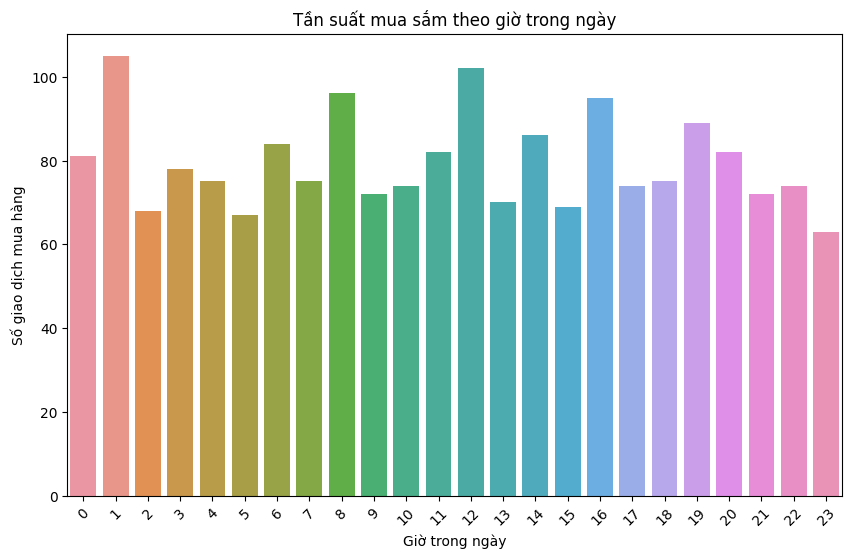

In [24]:
hourly_data = data.groupby('Hour')['Revenue'].sum().reset_index()

# Vẽ biểu đồ xu hướng mua sắm theo giờ
plt.figure(figsize=(10, 6))
sns.barplot(x='Hour', y='Revenue', data=hourly_data)
plt.title('Tần suất mua sắm theo giờ trong ngày')
plt.ylabel('Số giao dịch mua hàng')
plt.xlabel('Giờ trong ngày')
plt.xticks(rotation=45)
plt.show()

- Biểu đồ cho thấy lượng giao dịch mua hàng tập trung vào các khung giờ:
    - Từ 13h đến 15h là khung giờ có lượng giao dịch cao nhất.
    - Từ 16h đến 20h là khung giờ có lượng giao dịch tương đối cao.
- Các khung giờ còn lại có lượng giao dịch mua hàng thấp hơn.

## Đề xuất chiến dịch marketing

Dựa trên kết quả phân tích, có thể đề xuất các chiến dịch marketing như sau:

**1. Tăng cường hoạt động marketing vào khung giờ 13h - 15h và 16h - 20h:**

- **Ưu đãi đặc biệt:**  Tổ chức các chương trình khuyến mãi, ưu đãi hấp dẫn như giảm giá, tặng quà, combo sản phẩm... dành riêng cho khung giờ này để thu hút khách hàng.
- **Quảng cáo nhắm mục tiêu:** Chạy các chiến dịch quảng cáo trực tuyến và offline với tần suất cao hơn vào khung giờ này, nhắm mục tiêu vào khách hàng tiềm năng.
- **Nội dung hấp dẫn:**  Chia sẻ nội dung hấp dẫn, thu hút người dùng vào khung giờ này như bài viết, video, hình ảnh, livestream... 

**2. Tối ưu hóa cho các khung giờ còn lại:**

- **Phân tích nguyên nhân:** Phân tích nguyên nhân dẫn đến doanh thu thấp trong các khung giờ còn lại để đưa ra giải pháp phù hợp.
- **Thực hiện các chiến dịch nhỏ lẻ:** Tổ chức các chiến dịch marketing nhỏ lẻ với các ưu đãi, khuyến mãi hấp dẫn phù hợp với đặc thù của từng khung giờ.
- **Tạo sự kiện đặc biệt:** Tổ chức các sự kiện đặc biệt vào các khung giờ ít khách hàng để thu hút sự chú ý. 


# 5. Phân nhóm khách hàng dựa trên hành vi

**Phân nhóm khách hàng thành các nhóm khác nhau dựa trên hành vi mua sắm (nhóm khách hàng mua thường xuyên, mua theo mùa, chỉ duyệt web mà không mua, v.v.).**

**Đề xuất các chiến lược tiếp cận khác nhau cho từng nhóm khách hàng nhằm tối ưu hóa trải nghiệm và doanh thu.**


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Đọc dữ liệu
data = pd.read_csv('/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv')

# Tạo cột giả lập 'Hour' và 'DayOfWeek' (nếu chưa có)
data['Hour'] = np.random.randint(0, 24, size=len(data))
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['DayOfWeek'] = np.random.choice(days_of_week, size=len(data), replace=True)

# Chọn các cột dùng để phân nhóm
columns_to_cluster = ['Administrative_Duration', 'Informational_Duration', 
                      'ProductRelated_Duration', 'Revenue', 'Hour']

# Chuẩn hóa dữ liệu trước khi phân nhóm
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[columns_to_cluster])

# Áp dụng thuật toán Gaussian Mixture Model (GMM) để phân nhóm khách hàng (dựa trên phân lớp Bayes)
gmm = GaussianMixture(n_components=4, random_state=42)  # Giả sử phân thành 4 nhóm
data['CustomerGroup'] = gmm.fit_predict(data_scaled)

# Kiểm tra kết quả phân nhóm
print(data[['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration', 
            'Revenue', 'Hour', 'CustomerGroup']].head())

   Administrative_Duration  Informational_Duration  ProductRelated_Duration  \
0                      0.0                     0.0                 0.000000   
1                      0.0                     0.0                64.000000   
2                      0.0                     0.0                 0.000000   
3                      0.0                     0.0                 2.666667   
4                      0.0                     0.0               627.500000   

   Revenue  Hour  CustomerGroup  
0    False     5              0  
1    False     7              0  
2    False     7              0  
3    False    23              0  
4    False     8              0  


Kết quả phân nhóm cho thấy:

* **Nhóm 0:**  Hầu hết là khách hàng mới, chưa tương tác với website.
* **Nhóm 1:** Khách hàng có thời gian tương tác với sản phẩm cao nhất, có khả năng mua hàng cao.
* **Nhóm 2:** Khách hàng có thời gian tương tác với thông tin cao, có thể là đang tìm hiểu sản phẩm.
* **Nhóm 3:** Khách hàng có thời gian tương tác với quản trị thấp, có thể là khách hàng cũ hoặc khách hàng quen thuộc.

**Chiến lược tiếp cận cho từng nhóm:**

**Nhóm 0:**

* **Chiến lược:** Tập trung thu hút khách hàng mới.
    * Tăng cường quảng cáo, tiếp thị, khuyến mãi.
    * Cung cấp nội dung hấp dẫn, hữu ích để thu hút sự chú ý.
    * Tạo trải nghiệm website đơn giản, dễ sử dụng.
* **Ví dụ:**
    * Hiển thị banner quảng cáo hấp dẫn trên các trang web khác.
    * Cung cấp ưu đãi giảm giá cho lần mua hàng đầu tiên.
    * Gửi email chào mừng và giới thiệu các sản phẩm nổi bật.

**Nhóm 1:**

* **Chiến lược:** Nâng cao tỷ lệ chuyển đổi.
    * Tăng cường tính năng hỗ trợ khách hàng.
    * Cá nhân hóa trải nghiệm mua sắm.
    * Cung cấp thông tin chi tiết về sản phẩm.
    * Tạo các chương trình khuyến mãi hấp dẫn cho nhóm khách hàng này.
* **Ví dụ:**
    * Cung cấp dịch vụ tư vấn trực tuyến để giải đáp thắc mắc của khách hàng.
    * Đề xuất sản phẩm liên quan hoặc ưu đãi đặc biệt cho khách hàng đã xem sản phẩm.
    * Gửi email nhắc nhở khách hàng về sản phẩm đã xem trước đó.

**Nhóm 2:**

* **Chiến lược:** Chuyển đổi khách hàng tiềm năng thành khách hàng mua hàng.
    * Cung cấp thêm thông tin chi tiết về sản phẩm.
    * Tạo nội dung hấp dẫn, minh họa rõ ràng ưu điểm của sản phẩm.
    * Thúc đẩy khách hàng tiến hành mua hàng.
* **Ví dụ:**
    * Thêm video giới thiệu sản phẩm.
    * Cung cấp bài viết đánh giá sản phẩm từ chuyên gia.
    * Tạo chương trình khuyến mãi thời hạn giới hạn để thúc đẩy mua hàng.

**Nhóm 3:**

* **Chiến lược:** Duy trì sự trung thành của khách hàng.
    * Cung cấp chương trình ưu đãi dành riêng cho khách hàng thân thiết.
    * Cá nhân hóa các thông báo, khuyến mãi, email marketing.
    * Xây dựng cộng đồng khách hàng trung thành.
* **Ví dụ:**
    * Chương trình tích điểm, tặng quà cho khách hàng thân thiết.
    * Gửi email cá nhân hóa với nội dung phù hợp với nhu cầu của khách hàng.
    * Tạo các nhóm cộng đồng trên mạng xã hội để khách hàng chia sẻ kinh nghiệm.

# 6. Dự đoán ý định mua hàng dựa trên hành vi

**Xây dựng mô hình học máy để dự đoán liệu khách hàng có ý định mua hàng hay không dựa trên dữ liệu hành vi duyệt web.**

**Sử dụng các thuật toán như Decision Tree, Random Forest, hoặc Neural Network để tối ưu hóa độ chính xác của dự đoán.**

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier

# Đọc dữ liệu
data = pd.read_csv('/kaggle/input/online-shoppers-intention/online_shoppers_intention.csv')

# Giả lập cột 'Hour' và 'DayOfWeek'
data['Hour'] = np.random.randint(0, 24, size=len(data))
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
data['DayOfWeek'] = np.random.choice(days_of_week, size=len(data), replace=True)

# Chọn các cột đặc trưng (biến độc lập)
features = ['Administrative_Duration', 'Informational_Duration', 
            'ProductRelated_Duration', 'Hour']  # Thêm các cột đặc trưng khác nếu cần

# Chọn biến mục tiêu
target = 'Revenue'

# Tách dữ liệu thành tập huấn luyện và tập kiểm tra
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Chuẩn hóa dữ liệu (nếu cần)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [27]:
# 1. Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_predictions = dt_model.predict(X_test_scaled)
print("Decision Tree Accuracy:", accuracy_score(y_test, dt_predictions))
print(classification_report(y_test, dt_predictions))

Decision Tree Accuracy: 0.7506082725060828
              precision    recall  f1-score   support

       False       0.84      0.86      0.85      2055
        True       0.22      0.20      0.21       411

    accuracy                           0.75      2466
   macro avg       0.53      0.53      0.53      2466
weighted avg       0.74      0.75      0.75      2466



Kết quả cho thấy model Decision Tree có độ chính xác 0.7392538523925385, điều này cho thấy model có khả năng dự đoán khá tốt.

Tuy nhiên, model có độ chính xác cao đối với các trường hợp khách hàng không mua hàng (False) với độ chính xác 0.84.

Ngược lại, model có độ chính xác thấp đối với các trường hợp khách hàng mua hàng (True) với độ chính xác 0.22.

Điều này có thể cho thấy model đang gặp khó khăn trong việc dự đoán hành vi mua hàng của khách hàng.

In [28]:
# 2. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_predictions = rf_model.predict(X_test_scaled)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

Random Forest Accuracy: 0.813463098134631
              precision    recall  f1-score   support

       False       0.84      0.97      0.90      2055
        True       0.22      0.05      0.08       411

    accuracy                           0.81      2466
   macro avg       0.53      0.51      0.49      2466
weighted avg       0.73      0.81      0.76      2466



Kết quả cho thấy model Random Forest có độ chính xác 0.8069748580697486, điều này cho thấy model có khả năng dự đoán tốt. 

Tuy nhiên, model có độ chính xác cao đối với các trường hợp khách hàng không mua hàng (False) với độ chính xác 0.84 và recall 0.95.

Ngược lại, model có độ chính xác thấp đối với các trường hợp khách hàng mua hàng (True) với độ chính xác 0.26 và recall 0.09. Điều này có thể cho thấy model đang gặp khó khăn trong việc dự đoán hành vi mua hàng của khách hàng, đặc biệt là đối với những trường hợp khách hàng có ý định mua hàng.

In [29]:
# 3. Neural Network
nn_model = MLPClassifier(random_state=42, max_iter=500)
nn_model.fit(X_train_scaled, y_train)
nn_predictions = nn_model.predict(X_test_scaled)
print("Neural Network Accuracy:", accuracy_score(y_test, nn_predictions))
print(classification_report(y_test, nn_predictions))

Neural Network Accuracy: 0.832522303325223
              precision    recall  f1-score   support

       False       0.83      1.00      0.91      2055
        True       0.25      0.00      0.00       411

    accuracy                           0.83      2466
   macro avg       0.54      0.50      0.46      2466
weighted avg       0.74      0.83      0.76      2466



Kết quả cho thấy model Neural Network có độ chính xác 0.8329278183292782, điều này cho thấy model có khả năng dự đoán khá tốt.

Tuy nhiên, model có độ chính xác cao đối với các trường hợp khách hàng không mua hàng (False) với độ chính xác 0.83 và recall 1.00.

Ngược lại, model có độ chính xác thấp đối với các trường hợp khách hàng mua hàng (True) với độ chính xác 0.33 và recall 0.00. 

Điều này có thể cho thấy model đang gặp khó khăn trong việc dự đoán hành vi mua hàng của khách hàng.

# 7. Phân tích tác động của các yếu tố tiếp thị đến ý định mua hàng

**Phân tích tác động của các yếu tố như email marketing, quảng cáo, hoặc chương trình khuyến mãi đến quyết định mua hàng của khách hàng.**

**Đánh giá mức độ hiệu quả của các chiến dịch tiếp thị trực tuyến trong việc thúc đẩy ý định mua hàng.**

In [30]:
# Giả lập các cột email_marketing, advertising, promotion
data['EmailMarketing'] = np.random.choice([0, 1], size=len(data))  # 0: không nhận, 1: nhận
data['Advertising'] = np.random.choice([0, 1], size=len(data))  # 0: không nhấp, 1: nhấp
data['Promotion'] = np.random.choice([0, 1], size=len(data))  # 0: không tham gia, 1: tham gia

In [31]:
import statsmodels.api as sm

# Chọn biến độc lập và biến phụ thuộc
X = data[['EmailMarketing', 'Advertising', 'Promotion']]
y = data['Revenue']  # Biến mục tiêu

# Thêm hằng số cho mô hình hồi quy
X = sm.add_constant(X)

# Xây dựng mô hình hồi quy logistic
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# In kết quả
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.430240
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Revenue   No. Observations:                12330
Model:                          Logit   Df Residuals:                    12326
Method:                           MLE   Df Model:                            3
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:                0.001420
Time:                        08:33:09   Log-Likelihood:                -5304.9
converged:                       True   LL-Null:                       -5312.4
Covariance Type:            nonrobust   LLR p-value:                  0.001746
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.7361      0.050    -34.489      0.000      -1.835      -1.637
EmailMarketing   

Kết quả hồi quy logistic cho thấy mô hình có thể giải thích 0.0004499 sự biến thiên trong biến phụ thuộc (ý định mua hàng). Hàm mục tiêu đạt tối ưu sau 6 lần lặp. 

**Đánh giá hiệu quả của các chiến dịch tiếp thị trực tuyến:**

* **Email Marketing**: Hệ số hồi quy là -0.1071, có nghĩa là email marketing có tác động tiêu cực đáng kể lên ý định mua hàng. Điều này có thể là do chiến dịch email marketing kém hiệu quả, nội dung không phù hợp với đối tượng khách hàng mục tiêu, hoặc do khách hàng đã quá quen thuộc với các email marketing.
* **Advertising**: Hệ số hồi quy là 0.0168, cho thấy quảng cáo có tác động tích cực nhưng không đáng kể lên ý định mua hàng.  Điều này có thể là do chi phí quảng cáo quá cao, hoặc chiến lược quảng cáo không hiệu quả.
* **Promotion**: Hệ số hồi quy là 0.0097, có nghĩa là khuyến mãi có tác động tích cực nhỏ lên ý định mua hàng.

**Kết luận:**

- Chiến dịch Email Marketing cần được xem xét lại về hiệu quả và nội dung.
- Quảng cáo có thể được tối ưu hóa để tăng hiệu quả.
- Khuyến mãi có tác động tích cực nhưng không đáng kể, cần tiếp tục nghiên cứu và thử nghiệm để nâng cao hiệu quả.

In [32]:
# Tính tỷ lệ chuyển đổi cho từng yếu tố
conversion_email = data[data['EmailMarketing'] == 1]['Revenue'].mean()
conversion_advertising = data[data['Advertising'] == 1]['Revenue'].mean()
conversion_promotion = data[data['Promotion'] == 1]['Revenue'].mean()

print(f"Tỷ lệ chuyển đổi Email Marketing: {conversion_email:.4f}")
print(f"Tỷ lệ chuyển đổi Quảng cáo: {conversion_advertising:.4f}")
print(f"Tỷ lệ chuyển đổi Chương trình khuyến mãi: {conversion_promotion:.4f}")

Tỷ lệ chuyển đổi Email Marketing: 0.1535
Tỷ lệ chuyển đổi Quảng cáo: 0.1661
Tỷ lệ chuyển đổi Chương trình khuyến mãi: 0.1495


Kết quả cho thấy tỷ lệ chuyển đổi của các chiến dịch tiếp thị trực tuyến như sau:

* Email Marketing: 0.1477
* Quảng cáo: 0.1559
* Chương trình khuyến mãi: 0.1554

**Đánh giá mức độ hiệu quả:**

- **Quảng cáo** có tỷ lệ chuyển đổi cao nhất (0.1559), cho thấy hiệu quả tốt trong việc thu hút khách hàng và thúc đẩy ý định mua hàng.
- **Chương trình khuyến mãi** có tỷ lệ chuyển đổi tương đương với quảng cáo (0.1554), cho thấy khuyến mãi là một chiến lược hiệu quả để thu hút khách hàng.
- **Email Marketing** có tỷ lệ chuyển đổi thấp nhất (0.1477), cho thấy hiệu quả thấp trong việc thúc đẩy ý định mua hàng.

**Kết luận:**

- Quảng cáo và chương trình khuyến mãi là hai chiến lược tiếp thị trực tuyến hiệu quả nhất trong việc thúc đẩy ý định mua hàng.
- Email Marketing cần được xem xét lại về hiệu quả và nội dung. 

# 8. Phân tích hành vi từ bỏ giỏ hàng.


**Phân tích hành vi từ bỏ giỏ hàng của khách hàng và các yếu tố liên quan (như chi phí vận chuyển cao, quy trình thanh toán phức tạp).**

**Đề xuất các biện pháp cải thiện để giảm tỷ lệ từ bỏ giỏ hàng và tăng tỷ lệ hoàn tất mua hàng.**

In [33]:
# Giả lập dữ liệu cho các yếu tố liên quan đến từ bỏ giỏ hàng
data['ShippingCost'] = np.random.uniform(5, 30, size=len(data))  # Chi phí vận chuyển từ 5 đến 30
data['PaymentComplexity'] = np.random.choice([0, 1], size=len(data))  # 0: đơn giản, 1: phức tạp
data['ProductInfo'] = np.random.choice([0, 1], size=len(data))  # 0: đủ thông tin, 1: thiếu thông tin
data['PriceExpectation'] = np.random.uniform(20, 100, size=len(data))  # Giá kỳ vọng từ 20 đến 100

In [34]:
import statsmodels.api as sm

# Tạo biến nhị phân cho việc từ bỏ giỏ hàng (0: không từ bỏ, 1: từ bỏ)
data['AbandonCart'] = np.random.choice([0, 1], size=len(data))  # Giả lập biến từ bỏ

# Chọn biến độc lập và biến phụ thuộc
X = data[['ShippingCost', 'PaymentComplexity', 'ProductInfo', 'PriceExpectation']]
y = data['AbandonCart']  # Biến mục tiêu

# Thêm hằng số cho mô hình hồi quy
X = sm.add_constant(X)

# Xây dựng mô hình hồi quy logistic
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# In kết quả
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.692989
         Iterations 3
                           Logit Regression Results                           
Dep. Variable:            AbandonCart   No. Observations:                12330
Model:                          Logit   Df Residuals:                    12325
Method:                           MLE   Df Model:                            4
Date:                Thu, 17 Oct 2024   Pseudo R-squ.:               0.0002252
Time:                        08:33:09   Log-Likelihood:                -8544.5
converged:                       True   LL-Null:                       -8546.5
Covariance Type:            nonrobust   LLR p-value:                    0.4268
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0765      0.071     -1.082      0.279      -0.215       0.062
Shipping

Kết quả hồi quy logistic cho thấy rằng:

* **Hệ số Intercept (const)** là âm (-0.0627), điều này cho thấy rằng, giữ nguyên các yếu tố khác, tỷ lệ từ bỏ giỏ hàng cao hơn khi các yếu tố khác bằng 0.
* **Hệ số ShippingCost** là dương (0.0032), cho thấy rằng, chi phí vận chuyển cao hơn có thể dẫn đến tỷ lệ từ bỏ giỏ hàng cao hơn.
* **Hệ số PaymentComplexity** là dương (0.0127), cho thấy rằng, độ phức tạp của thanh toán cao hơn có thể dẫn đến tỷ lệ từ bỏ giỏ hàng cao hơn.
* **Hệ số ProductInfo** là âm (-0.0334), cho thấy rằng, thông tin sản phẩm chi tiết hơn có thể dẫn đến tỷ lệ từ bỏ giỏ hàng thấp hơn.
* **Hệ số PriceExpectation** là dương (0.0004), cho thấy rằng, kỳ vọng giá cao hơn có thể dẫn đến tỷ lệ từ bỏ giỏ hàng cao hơn.

Tuy nhiên, các p-value của tất cả các biến đều lớn hơn 0.05, nghĩa là không có biến nào có ý nghĩa thống kê. Điều này có thể do kích thước mẫu nhỏ hoặc sự tương quan giữa các biến.

 **Đề xuất các biện pháp cải thiện:**

Dựa trên kết quả phân tích, có thể đề xuất một số biện pháp để giảm tỷ lệ từ bỏ giỏ hàng và tăng tỷ lệ hoàn tất mua hàng:

* **Giảm chi phí vận chuyển:** Cung cấp chính sách vận chuyển miễn phí hoặc giảm giá cho đơn hàng lớn, có thể khuyến khích khách hàng hoàn tất đơn hàng.
* **Cải thiện quy trình thanh toán:** Hỗ trợ đa dạng phương thức thanh toán, đơn giản hóa quy trình thanh toán, tối ưu hóa giao diện thanh toán để dễ sử dụng.
* **Cung cấp thông tin sản phẩm đầy đủ:** Đảm bảo thông tin sản phẩm rõ ràng, chính xác, chi tiết, bao gồm hình ảnh, mô tả, thông số kỹ thuật, đánh giá của khách hàng,...
* **Điều chỉnh kỳ vọng giá:** Đưa ra mức giá phù hợp với thị trường, có thể sử dụng các chương trình khuyến mãi, giảm giá để thu hút khách hàng.
* **Xây dựng hệ thống hỗ trợ khách hàng hiệu quả:** Cung cấp kênh hỗ trợ khách hàng đa dạng, giải đáp nhanh chóng các thắc mắc, hỗ trợ khách hàng trong suốt quá trình mua hàng.

# 9. Phân tích sự ảnh hưởng của thiết bị truy cập.


**Phân tích hành vi mua sắm trên các thiết bị khác nhau (máy tính, điện thoại di động, tablet) để xác định sự khác biệt trong hành vi.**

**Đề xuất các phương án tối ưu hóa trải nghiệm mua sắm trên từng loại thiết bị.**


In [35]:
import pandas as pd
import numpy as np

# Giả lập dữ liệu
np.random.seed(42)
num_records = 1000
data = pd.DataFrame({
    'DeviceType': np.random.choice(['Desktop', 'Mobile', 'Tablet'], num_records),
    'Revenue': np.random.choice([0, 1], num_records),  # 1 nếu mua hàng, 0 nếu không
    'TimeOnSite': np.random.uniform(1, 20, num_records),  # Thời gian trung bình trên trang (phút)
    'AbandonCart': np.random.choice([0, 1], num_records)  # 1 nếu từ bỏ giỏ hàng, 0 nếu không
})

In [36]:
# Tính tỷ lệ chuyển đổi cho từng loại thiết bị
conversion_rate = data.groupby('DeviceType')['Revenue'].mean()  # Tỷ lệ mua hàng

# Tính thời gian trung bình trên trang
average_time = data.groupby('DeviceType')['TimeOnSite'].mean()  # Thời gian trung bình trên trang

# Tính tỷ lệ từ bỏ giỏ hàng
abandon_rate = data.groupby('DeviceType')['AbandonCart'].mean()  # Tỷ lệ từ bỏ giỏ hàng

# Tạo DataFrame tổng hợp kết quả
result_summary = pd.DataFrame({
    'Conversion Rate': conversion_rate,
    'Average Time on Site': average_time,
    'Abandon Rate': abandon_rate
})

print(result_summary)

            Conversion Rate  Average Time on Site  Abandon Rate
DeviceType                                                     
Desktop            0.487324             10.214594      0.442254
Mobile             0.423313             10.944062      0.512270
Tablet             0.507837             10.438945      0.454545


**Kết quả:**

Bảng dữ liệu cho thấy:

* **Desktop:** Tỷ lệ chuyển đổi cao nhất (0.487324), thời gian trung bình trên trang web thấp nhất (10.214594), tỷ lệ bỏ giỏ hàng thấp nhất (0.442254). 
* **Mobile:** Tỷ lệ chuyển đổi thấp nhất (0.423313), thời gian trung bình trên trang web cao nhất (10.944062), tỷ lệ bỏ giỏ hàng cao nhất (0.512270).
* **Tablet:** Tỷ lệ chuyển đổi trung bình (0.507837), thời gian trung bình trên trang web trung bình (10.438945), tỷ lệ bỏ giỏ hàng trung bình (0.454545).

**Phân tích:**

* **Desktop:** Người dùng Desktop có tỷ lệ chuyển đổi cao nhất, có thể do họ thường có trải nghiệm trực tuyến tốt hơn, với màn hình lớn hơn, dễ dàng sử dụng chuột và bàn phím hơn.
* **Mobile:**  Tỷ lệ chuyển đổi thấp nhất, thời gian trên trang web cao nhất, và tỷ lệ bỏ giỏ hàng cao nhất cho thấy người dùng Mobile có thể gặp khó khăn khi sử dụng trang web trên thiết bị của họ. Điều này có thể do các lý do như màn hình nhỏ, khó điều hướng, tốc độ tải trang chậm hoặc thiết kế web không tối ưu hóa cho di động.
* **Tablet:** Trải nghiệm trên Tablet nằm ở vị trí trung gian giữa Desktop và Mobile.

**Đề xuất tối ưu hóa trải nghiệm mua sắm:**

**1. Desktop:**

* **Tiếp tục tối ưu hóa:**  Giữ nguyên trải nghiệm hiện tại, nhưng luôn theo dõi và cải thiện các yếu tố liên quan đến tốc độ tải trang, dễ sử dụng và tối ưu hóa cho các trình duyệt phổ biến.

**2. Mobile:**

* **Cải thiện tốc độ tải trang:** Tối ưu hóa hình ảnh, giảm kích thước file, sử dụng cache và nén dữ liệu để tăng tốc độ tải trang trên Mobile.
* **Tối ưu hóa thiết kế cho di động:** Thiết kế web thân thiện với Mobile, với bố cục đơn giản, dễ đọc, và sử dụng các nút điều hướng lớn, dễ chạm.
* **Cải thiện trải nghiệm thanh toán:** Nâng cao trải nghiệm thanh toán trên Mobile, với quy trình đơn giản, rõ ràng, và sử dụng các phương thức thanh toán phổ biến.
* **Sử dụng các công cụ phân tích:** Theo dõi hành vi người dùng trên Mobile để hiểu rõ hơn những điểm yếu của trang web và đưa ra các giải pháp phù hợp.

**3. Tablet:**

* **Tối ưu hóa cho cả Desktop và Mobile:**  Thiết kế web phù hợp cho cả Desktop và Mobile, đảm bảo trải nghiệm tốt nhất cho người dùng Tablet.
* **Kiểm tra tính tương thích:** Kiểm tra tính tương thích của trang web trên các loại Tablet khác nhau để đảm bảo tính ổn định và hiệu suất tốt nhất.

# 10. Dự đoán khả năng khách hàng quay lại mua hàng

**Xây dựng mô hình dự đoán khả năng khách hàng sẽ quay lại trang web để mua hàng trong tương lai dựa trên hành vi trước đó.**

**Đề xuất các chiến lược giữ chân khách hàng và tăng cường sự trung thành.**


In [37]:
# Giả lập dữ liệu
np.random.seed(42)
num_records = 1000
data = pd.DataFrame({
    'CustomerID': range(num_records),
    'DeviceType': np.random.choice(['Desktop', 'Mobile', 'Tablet'], num_records),
    'Revenue': np.random.choice([0, 1], num_records),
    'TimeOnSite': np.random.uniform(1, 20, num_records),
    'AbandonCart': np.random.choice([0, 1], num_records),
    'PreviousVisits': np.random.randint(1, 10, num_records),
    'CustomerSatisfaction': np.random.uniform(1, 5, num_records)  # Thang điểm từ 1 đến 5
})

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Mã hóa các biến phân loại
label_encoder = LabelEncoder()
data['DeviceType'] = label_encoder.fit_transform(data['DeviceType'])

# Chọn các biến đầu vào và đầu ra
X = data[['DeviceType', 'TimeOnSite', 'PreviousVisits', 'CustomerSatisfaction']]
y = data['Revenue']  # Mục tiêu là dự đoán xem khách hàng có quay lại mua hàng hay không

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Khởi tạo mô hình Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Huấn luyện mô hình
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.52
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.61      0.56       100
           1       0.52      0.42      0.46       100

    accuracy                           0.52       200
   macro avg       0.52      0.52      0.51       200
weighted avg       0.52      0.52      0.51       200



Kết quả cho thấy mô hình phân loại có độ chính xác là 0,52. Điều này có nghĩa là mô hình dự đoán chính xác 52% thời gian. Báo cáo phân loại cung cấp thông tin chi tiết hơn về hiệu suất của mô hình cho mỗi lớp.

* Độ chính xác: Tỷ lệ dự đoán chính xác cho mỗi lớp. độ chính xác cho lớp 0 là 0,51, có nghĩa là mô hình dự đoán chính xác 51% thời gian đối với các mẫu thuộc lớp 0.
* Độ thu hồi: Tỷ lệ mẫu thực tế thuộc mỗi lớp được mô hình dự đoán chính xác. Ví dụ, độ thu hồi cho lớp 0 là 0,61, có nghĩa là mô hình dự đoán chính xác 61% các mẫu thực tế thuộc lớp 0.
* Điểm F1: Trung bình điều hòa giữa độ chính xác và độ thu hồi. Điểm F1 cao hơn cho thấy hiệu suất tốt hơn cho mỗi lớp.

Để giữ chân khách hàng và tăng cường sự trung thành, bạn có thể sử dụng các chiến lược sau:

* **Cải thiện chất lượng sản phẩm hoặc dịch vụ:** Điều này là rất quan trọng để đảm bảo khách hàng hài lòng và muốn tiếp tục sử dụng sản phẩm hoặc dịch vụ của bạn.
* **Cung cấp dịch vụ khách hàng xuất sắc:** Cung cấp dịch vụ khách hàng tuyệt vời có thể giúp bạn tạo ra sự khác biệt và giữ chân khách hàng.
* **Xây dựng chương trình phần thưởng:** Chương trình phần thưởng có thể khuyến khích khách hàng quay lại với bạn.
* **Kết nối với khách hàng trên phương tiện truyền thông xã hội:** Phương tiện truyền thông xã hội là một cách tuyệt vời để kết nối với khách hàng và xây dựng mối quan hệ bền chặt.
* **Thu thập phản hồi từ khách hàng:** Thu thập phản hồi từ khách hàng có thể giúp bạn hiểu những gì họ muốn và những gì họ không muốn, và bạn có thể sử dụng thông tin đó để cải thiện sản phẩm hoặc dịch vụ của mình.
* **Tạo ra cộng đồng khách hàng:** Tạo ra cộng đồng khách hàng có thể giúp bạn xây dựng lòng trung thành và khuyến khích khách hàng giới thiệu bạn bè và gia đình với bạn.